<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Introduction

In this notebook, I will try in a few hours to design an __algorithm that can visually diagnose melanoma, the deadliest form of skin cancer__. In particular, the algorithm will try to distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).

![title](images/skin_disease_classes.png)

# Install Prerequisites

In [50]:
# google colab does not come with torch installed. And also, in lesson we are 
# using torch v1.0 
# so following snippet of code installs the relevant version according to the 
# GPU architecture
!pip install -q torch==1.0.0 torchvision

!pip install -q livelossplot

!pip install -q --no-cache-dir -I pillow

# Download Data

In [0]:
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import io

from pathlib import Path

phases = ['train', 'valid', 'test']

In [28]:
for phase in phases:
  if not Path(f'/content/drive/data/{phase}').exists(): 
    if not Path(f'/content/drive/{phase}.zip').exists():     
      print(f'Downloading {phase}.zip')
      os.system(f'wget -nc https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/{phase}.zip -P "/content/drive/"')
      
    print(f'Extracting {phase}.zip')
    with zipfile.ZipFile(f'/content/drive/{phase}.zip', 'r') as myzip:
      myzip.extractall(path='/content/drive/data')

Extracting train.zip


# Explore Data

In [0]:
classes = [path.split('/')[-1] for path in sorted(glob.glob('/content/drive/data/train/*'))]

In [0]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
  
def print_images_distribution(show_max = False):
  image_repartition = pd.DataFrame(index=phases, columns=classes)

  for phase in phases:
      for disease in classes:
          image_repartition.loc[phase][disease] = len(glob.glob(f'/content/drive/data/{phase}/{disease}/*.jpg'))
          
  image_repartition['TOTAL'] = image_repartition.sum(axis=1)
  image_repartition['Ratio'] = np.round(image_repartition.TOTAL / image_repartition.TOTAL.sum() * 100, 1)
  
  if show_max:
    image_repartition = image_repartition.style.apply(highlight_max, axis=1, subset=classes)

  return image_repartition

In [31]:
print_images_distribution(True)

We can see we have a __class imbalance problem__ in this dataset: __nevus is much more represented__ while we are intererested to have high accuracy in predicting melanoma and seborrheic_keratosis. Without any change, the model will just learn to predict nevus. 

Fortunately, we can __download more samples__ from [ISIC Archive](https://www.isic-archive.com/#!/onlyHeaderTop/gallery).  

So let's download more samples:
- 1000 more samples of melanoma;
- 21 more samples of seborrheic_keratosis, and only, because all the other samples are already in the original dataset;
- 0 samples of nevus because it's already well represented.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [32]:
import glob
import zipfile
import io
import os

for disease in classes:
  for fn in sorted(glob.glob(f'/content/gdrive/My Drive/{disease}*.zip')):
    print('Extracting ' + fn)
    fn = fn.replace(' ', '\\ ')
    #os.system(f'mkdir -p /content/drive/data/train/{disease}')
    os.system(f'unzip {fn} -d /content/drive/data/train/' + fn.split('/')[-1].split('.')[0].split('-')[0])

Extracting /content/gdrive/My Drive/melanoma-1.zip
Extracting /content/gdrive/My Drive/melanoma-2.zip
Extracting /content/gdrive/My Drive/melanoma-3.zip
Extracting /content/gdrive/My Drive/melanoma-4.zip
Extracting /content/gdrive/My Drive/seborrheic_keratosis.zip


In [33]:
print_images_distribution()

melanoma nevus seborrheic_keratosis   TOTAL  Ratio
train     1374  1372                  275  3021.0   80.1
valid       30    78                   42   150.0    4.0
test       117   393                   90   600.0   15.9

We now have enough melanoma samples in train set. But still not enough __seborrheic_keratosis__. So I choose the __oversampling approach__ for this unbalanced class and I'll increase the number of observations which are just copies of existing samples.  

Moreover, the valid and test sets are still imbalanced. I'll keep the test set as it for the challenge purpose. But I can move some samples from train to valid set to have a better balance.

In [0]:
from os import listdir

def split_samples(valid_ratio = 0.0):
  for disease in ['melanoma', 'seborrheic_keratosis', 'nevus']:
    if os.path.exists('/content/drive/data/more/' + disease):
      files = [fn for fn in listdir('/content/drive/data/more/' + disease)]

      indices = list(range(len(files)))
      split = int(np.floor(valid_ratio * len(files)))

      np.random.shuffle(indices)

      train_idx, valid_idx = indices[split:], indices[:split]
      for idx in train_idx:
         os.system(f'mv /content/drive/data/more/{disease}/{files[idx]} /content/drive/data/train/{disease}/{files[idx]}')
      for idx in valid_idx:
         os.system(f'mv /content/drive/data/more/{disease}/{files[idx]} /content/drive/data/valid/{disease}/{files[idx]}')

In [35]:
def balance_valid_images():
  for disease, move_nb in {'seborrheic_keratosis': 136, 'melanoma': 148, 'nevus': 100}.items():
    for fn in glob.glob(f'/content/drive/data/train/{disease}/*.jpg')[0:move_nb]:
      dest = fn.replace('train', 'valid')
      os.system(f'mv {fn} {dest}')
      
balance_valid_images()
print_images_distribution()

melanoma nevus seborrheic_keratosis   TOTAL  Ratio
train     1226  1272                  139  2637.0   69.9
valid      178   178                  178   534.0   14.2
test       117   393                   90   600.0   15.9

In [0]:
#!rm -r /content/drive/data/train/melanoma/*-*.jpg
#!rm -r /content/drive/data/train/seborrheic_keratosis/*-*.jpg

In [37]:
import shutil

def duplicate_images(disease, copies):
  for fn in glob.glob(f'/content/drive/data/train/{disease}/*.jpg'):
    for i in range(2,copies+1):
      copy_fn = fn.replace('.', '-' + str(i) + '.')
      shutil.copyfile(fn,copy_fn)

duplicate_images('seborrheic_keratosis', 9)
#duplicate_images('melanoma', 4)

print_images_distribution()

melanoma nevus seborrheic_keratosis   TOTAL  Ratio
train     1226  1272                 1251  3749.0   76.8
valid      178   178                  178   534.0   10.9
test       117   393                   90   600.0   12.3

Now train and valid sets are well balanced.

# Data Augmentation

As there are "only" 2000 images in the training set, one way to enlarge the dataset is to "augmentate" the images by applying different chained transformations.    

I created two chained transformations:
 - one for validation and test with image resized and croped to 224x224 (or 299 for Inception v3), and then normalized;
 - one for training with some data augmentation: __random image rotation, random resized crop, random horizontal flip and finally random color jitter__.

In [0]:
import torchvision.transforms as transforms

model_name = 'densenet'

# All pre-trained models expect input images normalized in the same way,
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W),
# where H and W are expected to be at least 224 (299 for inception)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
image_size = 299 if model_name=='inception' else 224

transform = transforms.Compose([
                                transforms.Resize(image_size),
                                      transforms.CenterCrop(image_size),
                                #transforms.RandomResizedCrop(299),
                                transforms.RandomRotation(30),
                                #transforms.Lambda(lambda x : (x + torch.randn_like(x)) if random.random() < 0.2 else x),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                #transforms.RandomGrayscale(0.1),
                                transforms.ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4,hue=0.1),
                                transforms.ToTensor(),
                                normalize])

#specify a simpler transform for validation and test
test_transforms = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      normalize])

# Load Data

Three different data loaders are initialized for the three different sets of images: training, validation, and test.  
For each iteration, each data loader will return a batch of 64 images and perform one step of forward and back propagation.

In [0]:
import os
import torch

from torchvision import datasets
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import SubsetRandomSampler
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

train_data_dir = '/content/drive/data/train'
validation_data_dir = '/content/drive/data/valid'  
test_data_dir = '/content/drive/data/test'

train_data = datasets.ImageFolder(train_data_dir, transform=transform)
valid_data = datasets.ImageFolder(validation_data_dir, transform=test_transforms)
test_data = ImageFolderWithPaths(test_data_dir, transform=test_transforms)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, #sampler=train_sampler,
    num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, #sampler=valid_sampler, 
    num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)

loaders = {'train' : train_loader, 'valid': valid_loader, 'test': test_loader}

A single batch from the train set with data augmentation:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


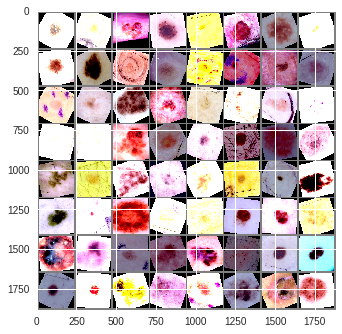

In [40]:
import torchvision
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

print('A single batch from the train set with data augmentation:')
dataiter = iter(loaders['train'])
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images, nrow=8, padding=10))

A single batch from the test set with NO data augmentation:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


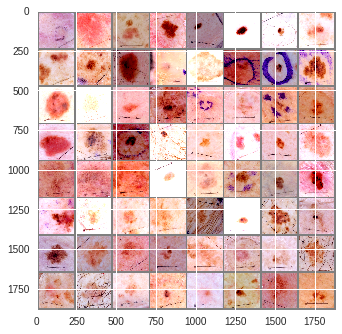

In [41]:
print('A single batch from the test set with NO data augmentation:')
dataiter = iter(loaders['test'])
images, labels, _ = dataiter.next()
imshow(torchvision.utils.make_grid(images, nrow=8, padding=10))

# Create a Model

Having satisfactory performance with a model created from scratch would take days or weeks to train... and still you have to train multiples architectures and pick the best one.  

__Transfer Learning__ is the reuse of a pre-trained model on a new problem. It is currently very popular in the field of Deep Learning because it enables you to train Deep Neural Networks with comparatively little data.
There are a some pre-trained Machine Learning models out there that became quite popular. One of them is the [DenseNet-161](https://arxiv.org/pdf/1608.06993.pdf) model, which was trained for the ImageNet “Large Visual Recognition Challenge”. In this challenge, participants had to classify images into 1000 classes, like “Zebra”, “Dalmatian”, and “Dishwasher”.

Despite the objects it was trained to classify are quite different compared to skin diseases images, the features detection part of such pretrained model are often reused to classify completely different images.  

I selected __[DenseNet-161](https://arxiv.org/pdf/1608.06993.pdf)__ as a good model to reuse because it has __improved performance over others on ImageNet__ and it introduces an interesting architecture with __each layer taking all preceding feature-maps as input__. Moreover despite it has a lot of layers, the time to train a single epoch is very similar to simpler pretrained models.

I also tried with [Inception v3](https://arxiv.org/abs/1512.00567), but did not get good results enough.

We just need two modifications to the pretrained model:
 - change the model so that it does not train these pretrained features anymore: requires_grad=False
 - and then __replace the last fully connected layer (the classifier itself) so that it outputs 3 classes__ instead of 1000.

I tried two different final classifiers and retained the first one:
- one layer with a single Linear classifier;
- two layers, with batch normalization to prevent vanishing gradients and dropout for regularization.
Both outputs raw scores that will later be transformed as probabilities using softmax.

In [0]:
import torchvision.models as models
import torch.nn as nn

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet161(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [45]:
feature_extract = True
model_transfer, input_size = initialize_model(model_name, len(classes), feature_extract, use_pretrained=True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
115730790it [00:04, 24078587.39it/s]


Now let's define a loss function and an optimizer:
- CrossEntropyLoss is the appropriate loss function for a classification model that outputs raw scores for each class;
- I initially selected Adam optimizer because it achieves good results fast. This algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision. It combines the advantages of two other extensions of stochastic gradient descent : AdaGrad and RMSProp. But at the end, AdaGrad gave me the faster results.

In [46]:
import torch.optim as optim
import time
import copy

# Send the model to GPU
model_transfer = model_transfer.to(device)

criterion_transfer = nn.CrossEntropyLoss() #torch.Tensor([5.347, 1.458, 7.874]).to(device))

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_transfer.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_transfer.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_transfer.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
            
optimizer_transfer = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 classifier.weight
	 classifier.bias


# Train the Model

The train function below will train the model for a given number of epochs.
After each epoch, it evaluates the model against the validation set, and its parameters are saved if validation loss has decreased. It's a good way to do early stopping.  

While training, it displays a live training and validation loss plot.

In [0]:
def get_model_path(model_name, extension):
  i = 1
  while len(glob.glob(f'{model_name}_{i}*.{extension}')):
    i+=1
  return f'{model_name}_{i}.{extension}'

In [0]:
import logging

def init_log(log_file):
  rootLogger = logging.getLogger()
  rootLogger.handlers = []
  rootLogger.setLevel(logging.INFO)

  fileHandler = logging.FileHandler(log_file)
  fileHandler.terminator = '\r\n'
  rootLogger.addHandler(fileHandler)

  consoleHandler = logging.StreamHandler()
  rootLogger.addHandler(consoleHandler)

In [0]:
from livelossplot import PlotLosses

def train_model(model, model_name, dataloaders, criterion, optimizer, num_epochs=25, best_loss = np.Inf):
    #https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

    liveloss = PlotLosses()
    model = model.to(device)
    
    save_path = get_model_path(model_name, 'pt')
    init_log(save_path.replace('.pt', '.log'))
    
    logging.info(f'Start training {model_name} model with {criterion} and {optimizer}')
    since = time.time()
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())

    try:
        for epoch in range(1, num_epochs+1):
            logs = {}
            logging.info('Epoch {}/{}'.format(epoch, num_epochs))
            logging.info('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        # Special case for inception because in training it has an auxiliary output. In train
                        #   mode we calculate the loss by summing the final output and the auxiliary output
                        #   but in testing we only consider the final output.
                        if model_name=="inception" and phase == 'train':
                            # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                            outputs, aux_outputs = model(inputs)
                            loss1 = criterion(outputs, labels)
                            loss2 = criterion(aux_outputs, labels)
                            loss = loss1 + 0.4*loss2
                        else:
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                saving_model = '=> Saving model' if phase == 'valid' and epoch_loss < best_loss else ''
                logging.info(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} {saving_model}')

                # deep copy the model
                if phase == 'valid' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())                    
                    torch.save(model.state_dict(), save_path.replace('.', f'_{best_loss:.3f}.'))
                    #torch.save(model.state_dict(), save_path + '{:.3f}'.format(epoch_acc) + '.pt')
                if phase == 'train':
                    train_acc_history.append(epoch_acc)
                else:
                    val_acc_history.append(epoch_acc)
                    
                prefix = ''
                if phase == 'valid':
                    prefix = 'val_'

                logs[prefix + 'log loss'] = epoch_loss
                logs[prefix + 'accuracy'] = epoch_acc
        
            liveloss.update(logs)
            liveloss.draw()

            logging.info('')
    
    except KeyboardInterrupt:
        logging.info('Training interrupted')
        pass
    
    time_elapsed = time.time() - since
    logging.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    logging.info(f'Best val Loss: {best_loss:4f}  Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

And now let's train the model:

In [0]:
# load the model that got the best validation accuracy from previous training sessions
#if os.path.exists('inception_1_53.3.pt'):
#model_transfer.load_state_dict(torch.load('densenet_1_0.803.pt'))

# train the model
n_epochs=20
model_transfer, train_acc_history, val_acc_history = train_model(model_transfer, model_name, loaders, criterion_transfer, optimizer_transfer, num_epochs=n_epochs)

Start training densenet model with CrossEntropyLoss() and Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Epoch 1/20
----------


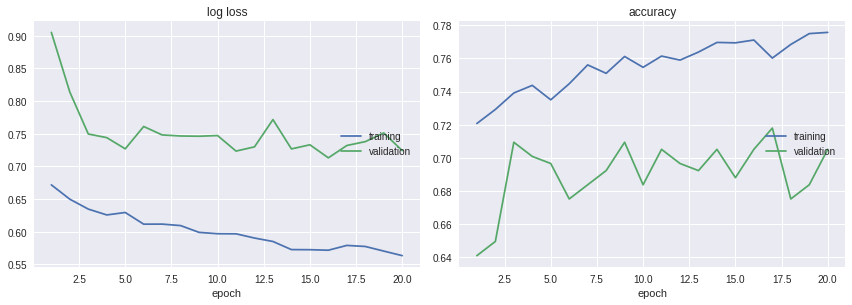


Epoch 21/40
----------


log loss:
training   (min:    0.563, max:    0.672, cur:    0.563)
validation (min:    0.713, max:    0.905, cur:    0.724)

accuracy:
training   (min:    0.721, max:    0.776, cur:    0.776)
validation (min:    0.641, max:    0.718, cur:    0.705)


Training interrupted
Training complete in 352m 30s
Best val Loss: 0.713047  Acc: 0.7051


In [89]:
# load the model that got the best validation accuracy from previous training sessions
#if os.path.exists('inception_1_53.3.pt'):
#model_transfer.load_state_dict(torch.load('densenet_1_0.803.pt'))

# train the model
n_epochs=40
model_transfer, train_acc_history, val_acc_history = train_model(model_transfer, model_name, loaders, criterion_transfer, optimizer_transfer, num_epochs=n_epochs)

# Evaluate the Model

## Get Predictions

The test function below calculate the test loss and accuracy of the model on the test set.  
It also returns a data frame with the probabilities of detection of melanoma and seborrheic keratoses in the given images. These probabilities will then be used to calculate the ROC AUC score of the model. 

In [0]:
def test_model(loaders, model, criterion):

    # monitor test loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    
    columns=['Id', 'melanoma', 'nevus', 'seborrheic_keratosis']
    probabilities = pd.DataFrame(columns=columns)

    model.eval()
    for inputs, labels, file_names in tqdm(loaders['test']):
        # move to GPU if any
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)            
            
            # statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            probs = torch.nn.Softmax(dim=1)(outputs.data).cpu().numpy()
            #probs = probs[:, [0,2]].cpu().numpy()
            probabilities = probabilities.append(
                pd.DataFrame({'Id': np.array([file_name[file_name.find('data'):].replace('\\','/') for file_name in file_names]), 
                              train_data.classes[0]: probs[:,0], 
                              train_data.classes[1]: probs[:,1], 
                              train_data.classes[2]: probs[:,2]}, columns=columns), ignore_index=True)
               
    epoch_loss = running_loss / len(loaders['test'].dataset)
    epoch_acc = running_corrects.double() / len(loaders['test'].dataset)
    
    logging.info(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return probabilities.sort_values('Id')

In [0]:
predictions = test_model(loaders, model_transfer, criterion_transfer)
# Adam 7 epochs
for disease in classes:
  print(predictions[predictions['Id'].str.contains(disease)].head(5))

In [0]:
for fn in sorted(glob.glob('*.pt')):
  model_transfer.load_state_dict(torch.load(fn))
  print('Predictions for ' + fn)
  predictions = test_model(loaders, model_transfer, criterion_transfer)
  print()

In [0]:
model_transfer.load_state_dict(torch.load(sorted(glob.glob('*.pt')[0]))

In [0]:
predictions = test_model(loaders, model_transfer, criterion_transfer)

In [92]:
predictions = test_model(loaders, model_transfer, criterion_transfer)
# Adagrad 21 epochs
for disease in classes:
  print(predictions[predictions['Id'].str.contains(disease)].head(5))

Test Loss: 1.0197 Acc: 0.5433


                                    Id  melanoma     nevus  \
0  data/test/melanoma/ISIC_0012258.jpg  0.203906  0.132053   
1  data/test/melanoma/ISIC_0012356.jpg  0.308359  0.538649   
2  data/test/melanoma/ISIC_0012369.jpg  0.260703  0.523661   
3  data/test/melanoma/ISIC_0012395.jpg  0.117096  0.070575   
4  data/test/melanoma/ISIC_0012425.jpg  0.044448  0.378872   

   seborrheic_keratosis  
0              0.664041  
1              0.152992  
2              0.215636  
3              0.812329  
4              0.576681  
                                   Id  melanoma     nevus  \
117  data/test/nevus/ISIC_0012092.jpg  0.006113  0.867379   
118  data/test/nevus/ISIC_0012095.jpg  0.015214  0.925060   
119  data/test/nevus/ISIC_0012147.jpg  0.048581  0.768602   
120  data/test/nevus/ISIC_0012149.jpg  0.230872  0.216201   
121  data/test/nevus/ISIC_0012152.jpg  0.059315  0.183701   

     seborrheic_keratosis  
117              0.126509  
118              0.059726  
119              0.1

## Get Results

Inspired by the ISIC challenge, the algorithm is ranked according to three separate categories:
- Category 1: ROC AUC for Melanoma Classification
- Category 2: ROC AUC for Melanocytic Classification
- Category 3: Mean ROC AUC

In [0]:
predictions = predictions.as_matrix(columns=[classes[0], classes[2]])

In [0]:
def get_ground_truth():
    # get ground truth labels for test dataset
    truth = pd.read_csv('ground_truth.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])
    return y_true

In [0]:
def get_predictions():
    # get ground truth labels for test dataset
    truth = pd.read_csv('predictions.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])
    return y_true

In [0]:
def get_sample_predictions():
    truth = pd.read_csv('sample_predictions.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])
    return y_true

In [0]:
from get_results import plot_roc_auc, plot_confusion_matrix

y_true = get_ground_truth()

plot_roc_auc(y_true, predictions)

In [0]:
def step(x, threshold=0):
    return np.sign(np.sign(x-threshold)+1)

def minimum_cost_threshold(y_true, y_pred, costs=(1, 1)):
    '''
    Find the decision threshold that minimizes the cost of errors.
    
    costs=(false_positive_cost, false_negative_cost)
    '''
    def error(x, costs):
        return costs[0]*step(-x, 0.99) + costs[1]*step(x,0.99)
    costs = np.array(costs)
    costs = costs/np.sum(costs)
    min_cost = np.inf
    min_threshold = 0
    for threshold in np.arange(0, 1, 0.001):
        y_pred_bin = np.ceil(y_pred - threshold)
#         cost = np.abs(y_true - y_pred_bin)*np.apply_along_axis(lambda i: costs[i[0]], 0, y_true)
        cost = error(y_true-y_pred_bin, costs)
        if np.mean(cost) < min_cost:
#             print(cost[:10])
            min_cost = np.mean(cost)
            min_threshold = threshold
    return min_threshold

def plot_best_confusion_matrix(y_true, y_pred, costs=(1,1)):
    threshold = minimum_cost_threshold(y_true, y_pred, costs=costs)
    print('Best threshold: %0.2f' % threshold)
    plot_confusion_matrix(y_true, y_pred, threshold, ['benign', 'malignant'])

In [0]:
plot_best_confusion_matrix(y_true[:, 0], predictions[:, 0], costs=(1,10))

In [0]:
plot_best_confusion_matrix(y_true[:, 1], predictions[:, 1], costs=(1,10))

# Conclusions

In a few hours, I was able to achieve a Mean ROC AUC score of 0.819. That would have been the 15th place in the initial challenge (see scores below). It's satisfying for what I wanted to achieve in a limited time.

Here are possible points of improvement to reach better results:
- more data augmentations techniques: randomly shift image, randomly convert image to grayscale...
- find more images: 2000 images is not a lot, I could download more images from [ISIC Archive](https://isic-archive.com/#images)
- try different architecture of the classifier
- try to unfreeze and then continue to train the features so that the feature detection adapts itself to skin diseases
- give a try to other transfer learning models : resnet, vgg16, Inception v3... 
- fine tune learning rate and other optimizer hyper parameters to speed up gradient descent
- give a try to other optimizers: AdaGrad, RMSProp, Adamax, Adadelta...
- train for more epochs as validation loss is still decreasing
- try different batch_size to see how it impacts training 
- display images where the model fails to understand why it fails and maybe improve algorithm, data augmentation

![title](images/cat_3.png)